In [3]:
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from matplotlib import pyplot as plt
import os
import numpy as np


/Users/noa/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def generate_program_refs(program):
    return {
        'model_performance': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/final_model_performance.tsv",sep='\t'),
        'all_models_performance': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/all_models_performance.tsv",sep='\t'),
        'feature_importance': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/final_model/full_model/model_standard_vi.tsv",sep='\t'),
        'test_data': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/final_model/test.tsv",sep='\t'), 
    'val_upgrade_data': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/final_model/val_upgrade.tsv",sep='\t'), 
     'val_downgrade_data': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/final_model/val_downgrade.tsv",sep='\t'),
     'val_standard_data': pd.read_csv(f"/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/{program}/final_model/val_standard.tsv",sep='\t')
     
    }


iqtree_refs = generate_program_refs("iqtree")
raxml_refs = generate_program_refs("raxml")
fasttree_refs = generate_program_refs("fasttree")


In [3]:
def calibration_plot(pred_dict,true,fig = None,ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for name in pred_dict:
        pred = pred_dict[name]
        true_calibrated, pred_calibrated = calibration_curve(true, pred, n_bins=15)
        # plot perfectly calibrated
        # plot model reliabilities
        ax.plot(true_calibrated, pred_calibrated, marker='.', label = name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    #ax.set_xlabel('True probabilities')
    #ax.set_ylabel('Predicted probabilities')
    fig.text(0.5, 0.04, 'Observation', ha='center', va='center')
    fig.text(0.06, 0.5, 'Prediction', ha='center', va='center', rotation='vertical')
    #ax.legend(bbox_to_anchor=(0,0))
    #ax.legend()
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
    
def programs_calibration_plot(iqtree_data,raxml_data,fasttree_data):  
    fig,axs = plt.subplots(ncols=1, nrows=3 )
    calibration_plot({'IQTREE ML model':iqtree_data['predictions_full_standard'],
    'IQTREE aLRT test':iqtree_data['predictions_aLRT_iqtree_raw_boot'],
                  'IQTREE Ultrafast':iqtree_data['predictions_bootstrap_support_raw_boot'],
                 'IQTREE aBayes test':iqtree_data['predictions_aBayes_iqtree_raw_boot'],
                 }, iqtree_data["true_binary_support"],fig,axs[0])


    calibration_plot({
                  'RAxML ML model':raxml_data['predictions_full_standard'],
    'RAxML bootstrap':raxml_data['predictions_bootstrap_support_raw_boot'],
                 }, raxml_data["true_binary_support"],fig,axs[1])


    calibration_plot({
                  'FastTree ML model':fasttree_data['predictions_full_standard'],
    'FastTree SH test':fasttree_data['predictions_bootstrap_support_raw_boot'],
                 }, fasttree_data["true_binary_support"],fig,axs[2])


    plt.show()
    
    


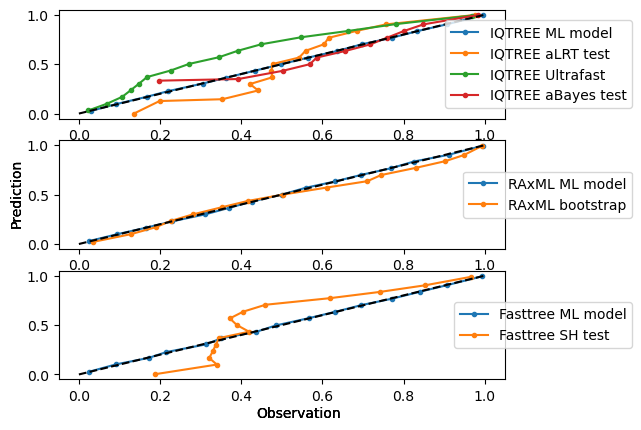

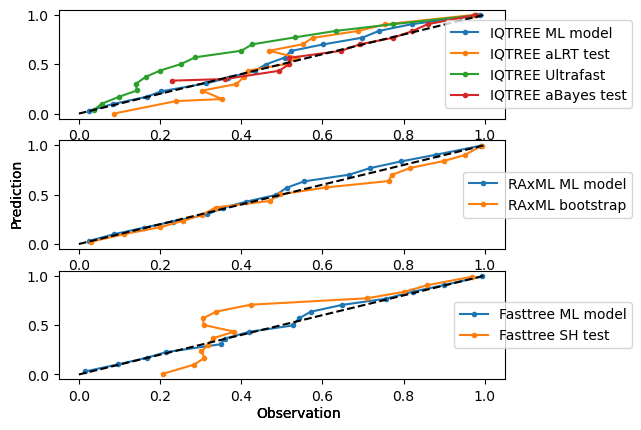

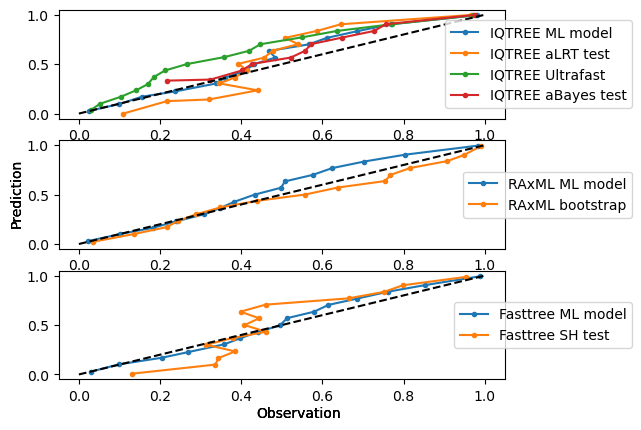

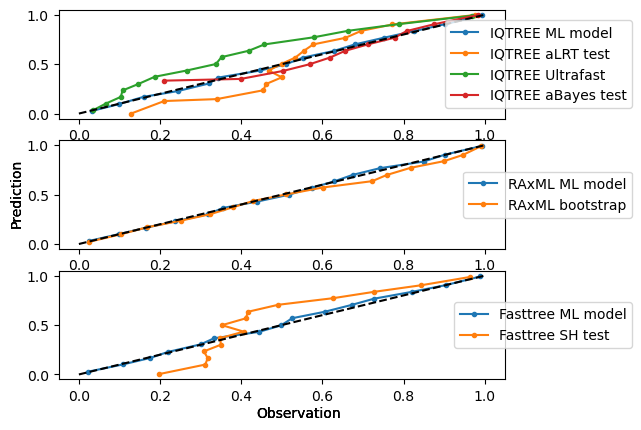

In [4]:
programs_calibration_plot(iqtree_refs["test_data"],raxml_refs["test_data"],fasttree_refs["test_data"])
programs_calibration_plot(iqtree_refs["val_upgrade_data"],raxml_refs["val_upgrade_data"],fasttree_refs["val_upgrade_data"])
programs_calibration_plot(iqtree_refs["val_downgrade_data"],raxml_refs["val_downgrade_data"],fasttree_refs["val_downgrade_data"])
programs_calibration_plot(iqtree_refs["val_standard_data"],raxml_refs["val_standard_data"],fasttree_refs["val_standard_data"])




In [9]:
def expected_calibration_error(samples, true_labels, M=30):
    # uniform binning approach with M number of bins
    # get max probability per sample i
    max_prob = np.max(samples, axis=1)
    predicted_label = np.argmax(samples, axis=1)
    correct_labels_indicator = predicted_label==true_labels
    ece = 0
    bins = np.linspace(0, 1, M + 1)
    for bin_lower, bin_upper in zip(bins[:-1], bins[1:]):
        probabilities_within_bin = np.logical_and(max_prob > bin_lower.item(), max_prob <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        pct_sampls_within_bin = probabilities_within_bin.mean()
        if pct_sampls_within_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_within_bin = correct_labels_indicator[probabilities_within_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            mean_max_prob_within_bin = max_prob[probabilities_within_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(mean_max_prob_within_bin - accuracy_within_bin) * pct_sampls_within_bin
    return ece

Calibration numerical metrics:

In [7]:
def get_IQTREE_dict(dataset):
#dataset = iqtree_refs["test_data"]
    programs_data = {'predictions':{'IQTREE ML model':dataset['predictions_full_standard'],
        'IQTREE aLRT test':dataset['predictions_aLRT_iqtree_raw_boot'],
                      'IQTREE Ultrafast':dataset['predictions_bootstrap_support_raw_boot'],
                     'IQTREE aBayes test':dataset['predictions_aBayes_iqtree_raw_boot'],
                     },'true':dataset["true_binary_support"]}
    return programs_data

        
def get_RAxML_dict(dataset):
#dataset = iqtree_refs["test_data"]
    programs_data = {'predictions':{
                  'RAxML ML model':dataset['predictions_full_standard'],
    'RAxML bootstrap':dataset['predictions_bootstrap_support_raw_boot'],
                 },'true':dataset["true_binary_support"]}
    return programs_data


def get_FastTree_dict(dataset):
#dataset = iqtree_refs["test_data"]
    programs_data = {'predictions':{
                  'FastTree ML model':dataset['predictions_full_standard'],
    'FastTree SH test':dataset['predictions_bootstrap_support_raw_boot'],
                 },'true':dataset["true_binary_support"]}
    return programs_data


In [10]:

def calibration_metrics(program_dict_func, dataset):
    program_dict = program_dict_func(dataset)
    for col in program_dict['predictions']:
        print(col)
        samples = np.column_stack((1-np.array(program_dict['predictions'][col]),
                                              np.array(program_dict['predictions'][col])))
        true = program_dict['true']
        print(expected_calibration_error(samples,true))
        
print("test")
calibration_metrics(get_IQTREE_dict,iqtree_refs["test_data"]) 
print("##")
calibration_metrics(get_RAxML_dict,raxml_refs["test_data"])
print("##")
calibration_metrics(get_FastTree_dict,fasttree_refs["test_data"])   

print("\n\n")

calibration_metrics(get_IQTREE_dict,iqtree_refs["val_upgrade_data"]) 
print("##")
calibration_metrics(get_RAxML_dict,raxml_refs["val_upgrade_data"])
print("##")
calibration_metrics(get_FastTree_dict,fasttree_refs["val_upgrade_data"])   

print("\n\n")

calibration_metrics(get_IQTREE_dict,iqtree_refs["val_downgrade_data"]) 
print("##")
calibration_metrics(get_RAxML_dict,raxml_refs["val_downgrade_data"])
print("##")
calibration_metrics(get_FastTree_dict,fasttree_refs["val_downgrade_data"])  
 


test
IQTREE ML model
0.002020479903397052
IQTREE aLRT test
0.04107815269852561
IQTREE Ultrafast
0.04097908544778591
IQTREE aBayes test
0.03256213929778679
##
RAxML ML model
0.002269825301605103
RAxML bootstrap
0.017026409819174394
##
FastTree ML model
0.0026547765568167778
FastTree SH test
0.05838406011050795



IQTREE ML model
0.011058907512395034
IQTREE aLRT test
0.04383565236760541
IQTREE Ultrafast
0.03789300762905343
IQTREE aBayes test
0.031449213891930915
##
RAxML ML model
0.006839360314464582
RAxML bootstrap
0.016719878232138677
##
FastTree ML model
0.005099398046218067
FastTree SH test
0.043478699905332936



IQTREE ML model
0.022780091138616166
IQTREE aLRT test
0.049130422845551226
IQTREE Ultrafast
0.04058740207050916
IQTREE aBayes test
0.038513659415220954
##
RAxML ML model
0.018951262813845873
RAxML bootstrap
0.018043333799664274
##
FastTree ML model
0.01452957734468736
FastTree SH test
0.061483456911024026


In [11]:
np.mean(iqtree_refs["test_data"]["predictions_full_standard"])

0.8245694973917623

In [5]:
from sklearn.metrics import roc_curve

def roc_comp_plot(pred_dict, true,fig = None,ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for name in pred_dict:
        pred = pred_dict[name]
        fpr , tpr, thresholds = roc_curve(true, pred)
        ax.plot(fpr, tpr, label = name)
    ax.plot([0,1],[0,1], 'k--')

    fig.text(0.5, 0.04, 'FPR', ha='center', va='center')
    fig.text(0.06, 0.5, 'TPR', ha='center', va='center', rotation='vertical')
    #ax.legend(bbox_to_anchor=(0,0))
    #ax.legend()
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
    


def programs_roc_plots(iqtree_data,raxml_data,fasttree_data):
    fig,axs = plt.subplots(ncols=1, nrows=3 )
    roc_comp_plot({'IQTREE ML model':iqtree_data['predictions_full_standard'],
        'IQTREE aLRT test':iqtree_data['predictions_aLRT_iqtree_raw_boot'],
                      'IQTREE Ultrafast':iqtree_data['predictions_bootstrap_support_raw_boot'],
                     'IQTREE aBayes test':iqtree_data['predictions_aBayes_iqtree_raw_boot'],
                     }, iqtree_data["true_binary_support"],fig,axs[0])


    roc_comp_plot({
                      'RAxML ML model':raxml_data['predictions_full_standard'],
        'RAxML bootstrap':raxml_data['predictions_bootstrap_support_raw_boot'],
                     }, raxml_data["true_binary_support"],fig,axs[1])


    roc_comp_plot({
                      'FastTree ML model':fasttree_data['predictions_full_standard'],
        'FastTree SH test':fasttree_data['predictions_bootstrap_support_raw_boot'],
                     }, fasttree_data["true_binary_support"],fig,axs[2])

    plt.show()

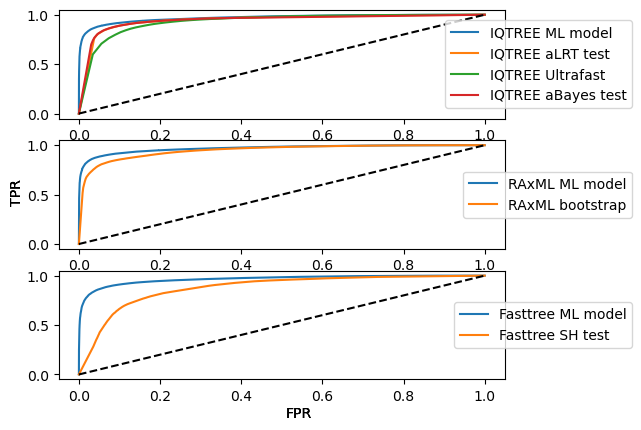

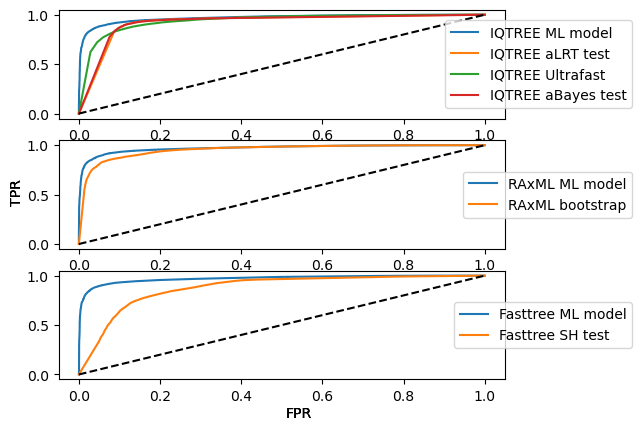

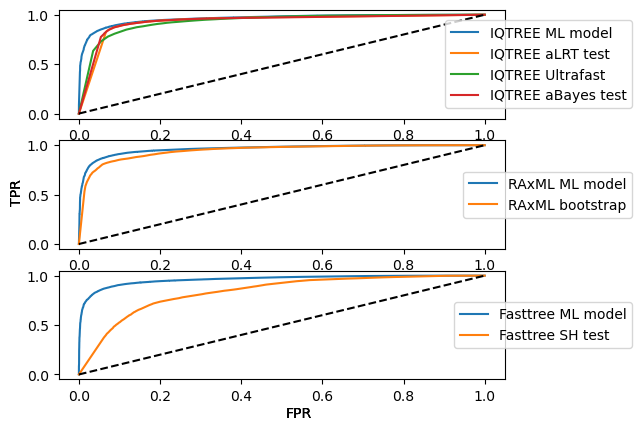

In [6]:
programs_roc_plots(iqtree_refs["test_data"],raxml_refs["test_data"],fasttree_refs["test_data"])
programs_roc_plots(iqtree_refs["val_upgrade_data"],raxml_refs["val_upgrade_data"],fasttree_refs["val_upgrade_data"])
programs_roc_plots(iqtree_refs["val_downgrade_data"],raxml_refs["val_downgrade_data"],fasttree_refs["val_downgrade_data"])

In [7]:
iqtree_translation_dict = {'full_standard-model_standard': 'All features',
                           'fast_standard-model_standard': 'All features except NNI features',
                           'bootstrap_support-raw_only_boot': 'Raw ultrafast bootstrap support',
                           'bootstrap_support-only_boot': 'Calibrated ultrafast bootstrap support',
                           'bootstrap_support-inc_boot': 'All features+ ultrafast bootstrap support',
                           'aLRT_iqtree-raw_only_boot': 'Raw aLRT support',
                           'aLRT_iqtree-only_boot': "Calibrated aLRT support",
                           'aLRT_iqtree-inc_boot': "All features+ aLRT support",
                           'aBayes_iqtree-raw_only_boot': 'Raw aBayes support',
                           'aBayes_iqtree-only_boot': "Calibrated aaBayes support",
                           'aBayes_iqtree-inc_boot': "All features+ aBayes support"

                           }

raxml_translation_dict = {'full_standard-model_standard': 'All features','fast_standard-model_standard':'All features except NNI features',
                   'bootstrap_support-raw_only_boot':'Raw standard bootstrap support','bootstrap_support-only_boot':'Calibrated standard bootstrap support',
                    'bootstrap_support-inc_boot':'All features + standard bootstrap support',           
                   }
fasttree_translation_dict = {'full_standard-model_standard': 'All features','fast_standard-model_standard':'All features except NNI features',
                   'bootstrap_support-raw_only_boot':'Raw SH support','bootstrap_support-only_boot':'Calibrated SH support',
                    'bootstrap_support-inc_boot':'All features + SH support',           
                   }
translate_datasets = {'val_upgrade':'Validation-JTT -> GTR+F+I+G',
                     'val_downgrade':'Validation-GTR+F+I+G -> JTT',
                      'val_standard':'Validation-control',
                      'test':'Test',
                      'train':'Train'
                     }
    

def edit_performance(models_performance_data, translation_dict, out_path):
    models_performance_data["concatenated_model"] = models_performance_data['analysis_type'].astype(str) +"-"+ models_performance_data["name"]
    models_performance_data["description"] = models_performance_data["concatenated_model"].apply(lambda x: translation_dict[x])
    models_performance_data["FPR"] = models_performance_data["fp_0.5"]/(models_performance_data["tn_0.5"]+models_performance_data["fp_0.5"])
    models_performance_data["FNR"] = models_performance_data["fn_0.5"]/(models_performance_data["tp_0.5"]+models_performance_data["fn_0.5"])
    models_performance_data["dataset"] = models_performance_data["dataset"].apply(lambda x: translate_datasets[x])
    models_performance_data = models_performance_data.round(3)
    out_df = models_performance_data[["description","dataset","AUC","logloss","brier_loss","mcc_0.5","FPR","FNR"]]
    out_df.to_csv(out_path,sep='\t')




In [8]:
main_results_path = '/Users/noa/Workspace/bootstrap_results/remote_results/ML_results'
edit_performance(iqtree_refs['model_performance'], iqtree_translation_dict, out_path = os.path.join(main_results_path,"iqtree/performance_text.tsv"))
edit_performance(fasttree_refs['model_performance'], fasttree_translation_dict, out_path = os.path.join(main_results_path,"fasttree/performance_text.tsv"))
edit_performance(raxml_refs['model_performance'], raxml_translation_dict, out_path = os.path.join(main_results_path,"raxml/performance_text.tsv"))

## Feature importance

In [9]:
translation_dict = {
    "feature_min_ll_diff": "Minimum log-likelihood difference between an NNI neighbour near the bipartition and current tree",
    "feature_max_ll_diff": "Maximum log-likelihood difference between an NNI neighbour near the split and current tree",

    'feature_fbp_pars': "Fraction of parsimoy trees in which the bipartition exists",
    'feature_fbp_pars_min_bipart': "Minimum neighbour Bipartition Presence Ratio across parsimony trees",
    'feature_fbp_pars_mean_bipart': "Mean neighbour Bipartition Presence Ratio across parsimony trees",
    
    'feature_tbe_pars': "Mean Transfer Distance of the bipartition across parsimoy trees",
        'feature_tbe_pars_min_bipart': "Minimum of mean Transfer Distance from Neighbouring Bipartitions to parsimony Trees",
    'feature_tbe_pars_mean_bipart': "Overall mean of Transfer Distance from Neighbouring Bipartitions to parsimony Trees",
        
    'feature_tbe_MLEs': "Mean Transfer Distance of the bipartition across final ML trees",
    'feature_tbe_MLEs_min_bipart': "Minimum of mean Transfer Distance from Neighbouring Bipartitions to final ML trees Trees",
    'feature_tbe_MLEs_mean_bipart': "Mean Neighbour Bipartition Presence Ratio across final ML trees",
    
    'feature_fbp_MLEs': "Fraction of final ML trees in which the bipartition exists",
    'feature_fbp_MLEs_min_bipart': "Minimum Neighbour Bipartition Presence Ratio across final ML trees",
    'feature_fbp_MLEs_mean_bipart': "Mean Neighbour Bipartition Presence Ratio across final ML trees",

    'feature_partition_branch': 'Branch length at the parititon',
    'feature_partition_branch_vs_mean': 'Branch length at the parititon divided by total tree divergence',

    'feature_mean_bl_bipart':'Mean branch length among the neighbouring branches',
    'feature_min_bl_bipart': 'Minimal branch length among the neighbouring branches',
    'feature_max_bl_bipart': 'Maximal branch length among the neighbouring branches',
    'feature_min_vs_max_bl_bipart': 'The division of the minimum branch length by the maximum branch length  among the neighbouring branches',
    'feature_var_bl_bipart':'Variance of branch length among the neighbouring branches',
'feature_partition_branch_vs_bipart_mean':'Branch length divided by mean branch length among the neighbouring branches',

    'feature_partition_divergence': 'Total divergence in the smaller subtree defined by the bipartition',
    'feature_divergence_ratio': 'Total divergence in the smaller subtree defined by the bipartition divided by total tree divergence',
    'feature_partition_size': 'Number of leaves in the smaller subtree defined by the bipartition',
    'feature_partition_size_ratio': 'Fraction of leaves in the smaller subtree defined by the bipartition',

    'feature_total_tree_divergence':'Total tree divergence',
    'feature_tree_mad_score':'Tree MAD score',
    'feature_var_bl': 'Variance of branch lengths across the tree',
    'feature_25_pct_bl': '25th percentile of tree branch lengths',
    'feature_75_pct_bl': '75th percentile of tree branch lengths',
    'feature_median_bl': 'Median of tree branch lengths',
    'feature_skew_bl': 'Skewness of tree branch lengths',
    'feature_kurtosis_bl': 'Kurtosis of tree branch lengths',


    'feature_msa_constant_sites_pct': 'Fraction of constant sites among the MSA sites',
    'feature_msa_n_loci': 'Number of positions in the MSA',
    'feature_msa_n_unique_sites': 'Number of unique positions in the MSA',
    'feature_msa_n_seq': 'Number of sequences in the MSA',
    'feature_msa_pypythia_msa_difficulty': 'MSA difficulty',
}

In [10]:
main_results_path = '/Users/noa/Workspace/bootstrap_results/remote_results/ML_results'
iqtree_vi = iqtree_refs['feature_importance'].copy()
iqtree_vi['description'] = iqtree_vi['Unnamed: 0'].map(translation_dict)
iqtree_vi.sort_values('Gini-importance', ascending=False, inplace = True)
iqtree_vi['Gini-importance'] = iqtree_vi['Gini-importance'].apply(lambda x: round(x))
iqtree_vi['Gini-importance'] = iqtree_vi.apply(lambda x: "{:,}".format(x['Gini-importance']), axis=1)
iqtree_vi = iqtree_vi.round(3)
iqtree_vi[["description","Gini-importance","auc","mcc"]].to_csv(os.path.join(main_results_path,'iqtree/vi_text.tsv'), sep='\t')
###
raxml_vi = raxml_refs['feature_importance'].copy()
raxml_vi.sort_values('Gini-importance', ascending=False, inplace = True)
raxml_vi['description'] = raxml_vi['Unnamed: 0'].map(translation_dict)
raxml_vi['Gini-importance'] = raxml_vi['Gini-importance'].apply(lambda x: round(x))
raxml_vi['Gini-importance'] = raxml_vi.apply(lambda x: "{:,}".format(x['Gini-importance']), axis=1)
raxml_vi = raxml_vi.round(3)
raxml_vi[["description","Gini-importance","auc","mcc"]].to_csv(os.path.join(main_results_path,'raxml/vi_text.tsv'), sep='\t')
###
fasttree_vi = fasttree_refs['feature_importance'].copy()
fasttree_vi.sort_values('Gini-importance', ascending=False, inplace = True)
fasttree_vi['description'] = fasttree_vi['Unnamed: 0'].map(translation_dict)
fasttree_vi['Gini-importance'] = fasttree_vi['Gini-importance'].apply(lambda x: round(x))
fasttree_vi['Gini-importance'] = fasttree_vi.apply(lambda x: "{:,}".format(x['Gini-importance']), axis=1)
fasttree_vi = fasttree_vi.round(3)
fasttree_vi[["description","Gini-importance","auc","mcc"]].to_csv(os.path.join(main_results_path,'fasttree/vi_text.tsv'), sep='\t')

### Factors affecting model performance

In [14]:
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np

cols = ['feature_msa_n_seq','feature_msa_n_loci','feature_msa_pypythia_msa_difficulty',
        'true_binary_support','predictions_full_standard']

iqtree_test_data = iqtree_refs['test_data'][cols]
iqtree_test_data['program'] = 'IQTREE'
raxml_test_data = raxml_refs['test_data'][cols]
raxml_test_data['program'] = 'RAxML'
fasttree_test_data = fasttree_refs['test_data'][cols]
fasttree_test_data['program'] = 'FastTree'
all_programs_test_data = pd.concat([iqtree_test_data,raxml_test_data,fasttree_test_data])

iqtree_model_performance = iqtree_refs['all_models_performance']
iqtree_model_performance['program'] = 'IQTREE'
raxml_model_performance = raxml_refs['all_models_performance']
raxml_model_performance['program'] = 'RAxML'
fasttree_model_performance = fasttree_refs['all_models_performance']
fasttree_model_performance['program'] = 'FastTree'
all_programs_model_performance = pd.concat([iqtree_model_performance,raxml_model_performance,fasttree_model_performance])

/var/folders/tq/zxd_j92j2dv80nh2m_d741fr0000gn/T/ipykernel_28337/78749588.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iqtree_test_data['program'] = 'IQTREE'
/var/folders/tq/zxd_j92j2dv80nh2m_d741fr0000gn/T/ipykernel_28337/78749588.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raxml_test_data['program'] = 'RAxML'
/var/folders/tq/zxd_j92j2dv80nh2m_d741fr0000gn/T/ipykernel_28337/78749588.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

/var/folders/tq/zxd_j92j2dv80nh2m_d741fr0000gn/T/ipykernel_28337/3890469496.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_programs_model_performance_filtered["Number of training MSAs"] = all_programs_model_performance_filtered["sample_frac"]*4610


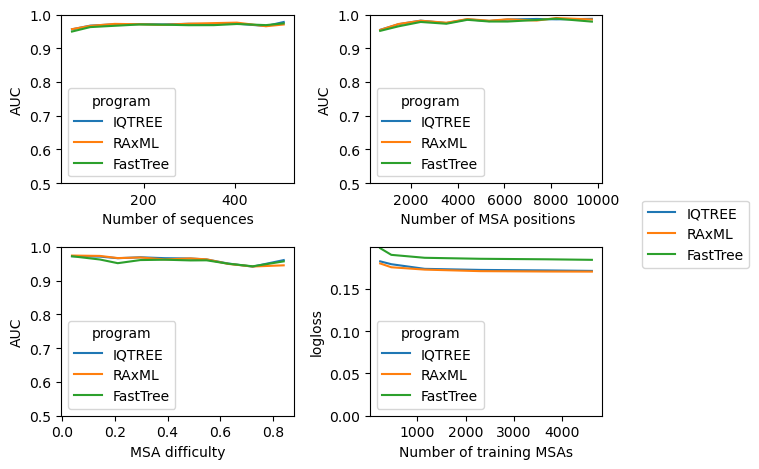

In [44]:
fig,axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()

hue_order = ['IQTREE', 'RAxML', 'FastTree']


columns_dict = {'feature_msa_n_seq':'Number of sequences','feature_msa_n_loci': ' Number of MSA positions',
                'feature_msa_pypythia_msa_difficulty': 'MSA difficulty'}
for i,col in enumerate(columns_dict):
    all_programs_test_data['binned_col'] = pd.cut(all_programs_test_data[col], 10)
    grouped_df = all_programs_test_data.groupby(['binned_col','program'])
    grouped_df_data = grouped_df.agg(median_per_group = (col,np.median)).reset_index()
    auc_scores = []

    for name, group in grouped_df:
        # Assume 'target' is the column representing the binary classification outcome
        y_true = group['true_binary_support']
        y_scores = group['predictions_full_standard']
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)

    grouped_df_data['AUC'] = auc_scores
    sns.lineplot(data=grouped_df_data, x="median_per_group", y="AUC", hue = "program", hue_order= hue_order,ax=axs[i])
    axs[i].set_ylim(0.5,1)
    axs[i].set_xlabel(columns_dict[col])
    #axs[i].get_legend().remove()
    #plt.show()


    
all_programs_model_performance_filtered = all_programs_model_performance.query("`dataset`=='test' and `name` =='model_standard' and `analysis_type`=='full_standard'")
all_programs_model_performance_filtered["Number of training MSAs"] = all_programs_model_performance_filtered["sample_frac"]*4610
sns.lineplot(data=all_programs_model_performance_filtered, x="Number of training MSAs", y="logloss", hue = "program",hue_order = hue_order,ax=axs[-1])
#axs[-1].get_legend().remove()
axs[-1].set_ylim(0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent overlapping
plt.tight_layout()

In [37]:
d = raxml_refs['all_models_performance'][['sample_frac','analysis_type','dataset','logloss'] ]
d.loc[d.dataset=='test']
#raxml_refs['all_models_performance'].columns

,sample_frac,analysis_type,dataset,logloss
0,0.05,full_standard,test,0.179822
5,0.05,fast_standard,test,0.189705
10,0.10,full_standard,test,0.175332
15,0.10,fast_standard,test,0.184393
20,0.25,full_standard,test,0.172569
25,0.25,fast_standard,test,0.179856
30,0.50,full_standard,test,0.170747
35,0.50,fast_standard,test,0.177090
40,0.80,full_standard,test,0.170310
45,0.80,fast_standard,test,0.176585


/var/folders/tq/zxd_j92j2dv80nh2m_d741fr0000gn/T/ipykernel_28337/496293078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_programs_model_performance_filtered["Number of training MSAs"] = all_programs_model_performance_filtered["sample_frac"]*4610


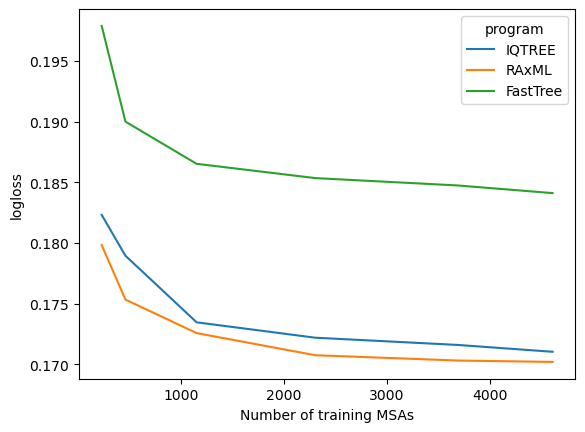

In [40]:
all_programs_model_performance_filtered = all_programs_model_performance.query("`dataset`=='test' and `name` =='model_standard' and `analysis_type`=='full_standard'")
all_programs_model_performance_filtered["Number of training MSAs"] = all_programs_model_performance_filtered["sample_frac"]*4610
sns.lineplot(data=all_programs_model_performance_filtered, x="Number of training MSAs", y="logloss", hue = "program")
#axs[-1].get_legend().remove()
plt.show()